# Classification model for Taiwanese companies bankruptcy
## Introduction
Can a company’s upcoming bankruptcy be predicted? The Taiwanese Economic Journal sought to address this question with the dataset titled “Taiwanese Bankruptcy Prediction”. This dataset compiles quantitative data pertaining to 6,819 companies along one main categorial variable: 0 for solvent, 1 for bankrupt. In addition to the categorical variable, this dataset includes values for 95 variables regarding each company’s financial and operational statuses, which might be used as predictors for insolvency. It is important to note that this dataset was gathered in Taiwan over a period of ten years (1999-2009), so we expect that it captures valuable insight to support the idea that bankruptcy can be predicted ahead of time with enough information regarding its current and historical operations. It is important to point out that this context includes the effects of the 2008 financial crisis. Someone may claim that, because of this, the data will not be representative of periods where the market is stable; however, we believe that conclusions extracted from this dataset might still be relevant given that the COVID-19 pandemic and various other economic circumstances have compounded to cause significant distress in the market.

To choose our potential predictors, we took into account the main challenges that businesses are facing nowadays. The rapidly-evolving industry – for example, the rapid development of generative artificial intelligence – and unstable market circumstances – for example, the supply chain disruptions caused by geopolitical conflict in key areas of resource extraction – mean that a key strategic priority ought to be concentrated on keeping pace with competitors or maintaining flexibility within one’s own market space. We have chosen to focus on the “keeping pace” side, as compared to market share. Hsiao et al. (2021) state that innovation is a significant indicator of a firm’s long-term growth. Therefore, out of the 95 possible predictive variables, we chose to examine "Research and Development Expenses" and "Net Sales and Total Equity Growth". We thought these were particularly interesting since they pertain to a company’s strategic approach towards future growth. It is widely found in most literature on the matter that “R&D has a significantly positive effect on innovation activity and productivity” (Acs et al., 1992; Noya et al., 2013, as cited by Hsiao et al., 2021). While some industries may be less competitive in this respect, technology transfer and knowledge capital are particularly important to maintain competitiveness in high-technology industries (Santamaría et al., 2009, as cited by Hsiao et al., 2021).

As such, our research question is as follows: by examining future growth investment through a company’s research and development expenditures, and its total equity growth, might one be able to form a reliable predictive model indicating whether or not it is likely to go bankrupt in the near future? Our current hypothesis is that companies which are investing more capital in forward-looking projects are less likely to go bankrupt, as they will have better-investigated plans for their future trajectories, and currently have adequate resources to manage everyday operations as well as look into this trajectory. A preliminary analysis showed that these variables were, in many cases, able to predict the near-future bankruptcy status of a particular observation.

By investigating these factors, we hope to get a sense of how proactive business practices can be indicative of future success. This might be helpful to implement in resource allocation strategy going forward. That is, it might help companies to make better decisions regarding how to divide their budget to both invest in future viability via research and development and continue to grow or scale simultaneously. This could also be valuable information for the investors of the Taiwanese stock market, which is predominantly formed by domestic individual investors, who “tend to have less professional knowledge and cannot access information accurately and easily” (Demirer et al., 2010). 

## Methods and results
To perform the statistical analysis, some R libraries such as Tidyverse and Tidymodels were used. This Jupyter notebook uses the libraries preinstalled in the `ubcdsci/r-dsci-100` Docker image; in addition, the library Themis had to be installed.

In [1]:
# Install themis library
install.packages("themis")

# Import necessary libraries
library(tidyverse)
library(tidymodels)
library(themis)
library(janitor)
library(RColorBrewer)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── t

First of all, the dataset was downloaded from the Internet and cleaned into a tidy format.

In [2]:
# Read dataset into R
# For exploration we are selecting the data we are going to use because there are too many columns
# and renaming all of them here would get long.
download.file("https://raw.githubusercontent.com/GaryHilares/dsci100-2023w1-group00820/main/data.csv",
              "taiwanese_data.csv")
taiwanese_data <- read_csv("taiwanese_data.csv") |>
                  clean_names() |>
                  select(bankrupt, research_and_development_expense_rate, equity_to_liability) |>
                  mutate(bankrupt = recode(as.factor(bankrupt), "0" = "No", "1" = "Yes")) |>
                  drop_na()
head(taiwanese_data)

Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): Bankrupt?, ROA(C) before interest and depreciation before interest...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


bankrupt,research_and_development_expense_rate,equity_to_liability
<fct>,<dbl>,<dbl>
Yes,0,0.01646874
Yes,0,0.02079431
Yes,25500000,0.01647411
Yes,0,0.02398233
Yes,0,0.03549020
Yes,0,0.01953448


Then, we split the dataset into training and testing sets, using a 75% to 25% proportion and keeping the amount of bankruptcy observations proportional on both groups.

In [3]:
set.seed(123)

taiwanese_split <- initial_split(taiwanese_data, prop = 0.75, strat = bankrupt)
taiwanese_training <- training(taiwanese_split)
taiwanese_testing <- testing(taiwanese_split)

Following this, we counted the total amount of observations per each label on the training data.

In [4]:
# Summarize the amount of observations that we have per each label
taiwanese_training |> group_by(bankrupt) |> summarize(count = n())

bankrupt,count
<fct>,<int>
No,4941
Yes,173


Here, a big imbalance can be seen between the "Yes" label, which had 173 observations, and the "No" label, which had 4941 observations. If left unchecked, this imbalance would cause our predictive model to predict "No" more often than appropiate, as this would lead to a higher accuracy but lower recall and predictive power. As a result, we decided to undersample the data in a later step of the process.

To check for potential correlation, we visualized the data using a scatter plot. To prevent major overplotting, we took a subsample of 750 observations rather than the whole training dataset, which includes 5114 points.

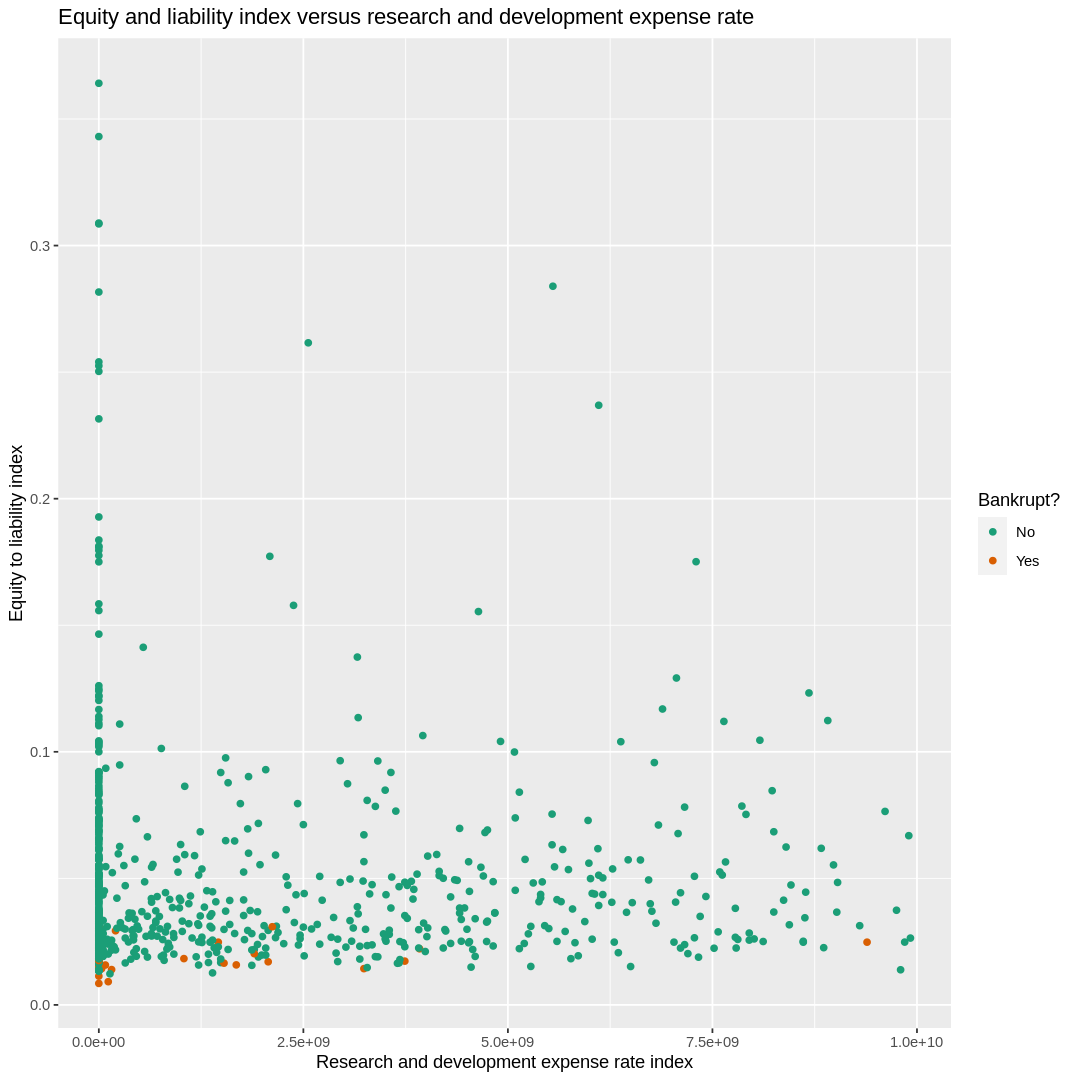

In [5]:
set.seed(344)

options(repr.plot.width = 9, repr.plot.height = 9)
taiwanese_training |> sample_n(750, replace = FALSE) |>
                      ggplot(aes(x = research_and_development_expense_rate,
                                 y = equity_to_liability,
                                 color = bankrupt)) +
                      geom_point() +
                      labs(title = "Equity and liability index versus research and development expense rate",
                           x = "Research and development expense rate index",
                           y = "Equity to liability index",
                           color = "Bankrupt?") +
                      scale_color_brewer(palette = "Dark2")

In this plot, the great label imbalance mentioned before can also be observed. In addition, the plot shows that this dataset is unlikely to be able to be classified using logistic regression. However, the datapoints seem to form distinct groups, such as the big column of "No" datapoints located to the left of the plot. There also seems to be a concentration of "Yes" datapoints to the bottom left of the graph, which we expect to become a majority after we undersample the "No" datapoints. The way in which the datapoints form groups suggest that using a K-NN model is likely to give good predictions for this particular dataset. Another important observation is that both variables have very different ranges: the research and development expense rate index ranges from 0 to ~10^10 while the equity to liability index ranges from 0 to ~0.45. This suggests that we should normalize our data, so that one variable does not influence our model more than the other.

We tuned the value of neighbors to be used in our model by training a set of classifiers with K values from 1 to 20, inclusive. As foreshadowed before, we downsampled the "No" observation and normalized our data. Moreover, to increase the reliability of each of the models, we used 5-fold cross-validation, which should reduce the likelihood that we get a bad validation set split by chance.

In [6]:
set.seed(3489)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
taiwanese_folds <- taiwanese_training |> vfold_cv(v = 5, strata = bankrupt)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
taiwanese_recipe <- recipe(bankrupt ~ research_and_development_expense_rate + equity_to_liability,
                           data = taiwanese_training) |>
                    step_downsample(bankrupt, under_ratio = 1, skip = TRUE) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())
taiwanese_metrics <- workflow() |>
                     add_recipe(taiwanese_recipe) |>
                     add_model(knn_spec) |>
                     tune_grid(resamples = taiwanese_folds, grid = k_vals) |>
                     collect_metrics()

Then, we visualized the accuracy for each value of K to see which K was the best for our model.

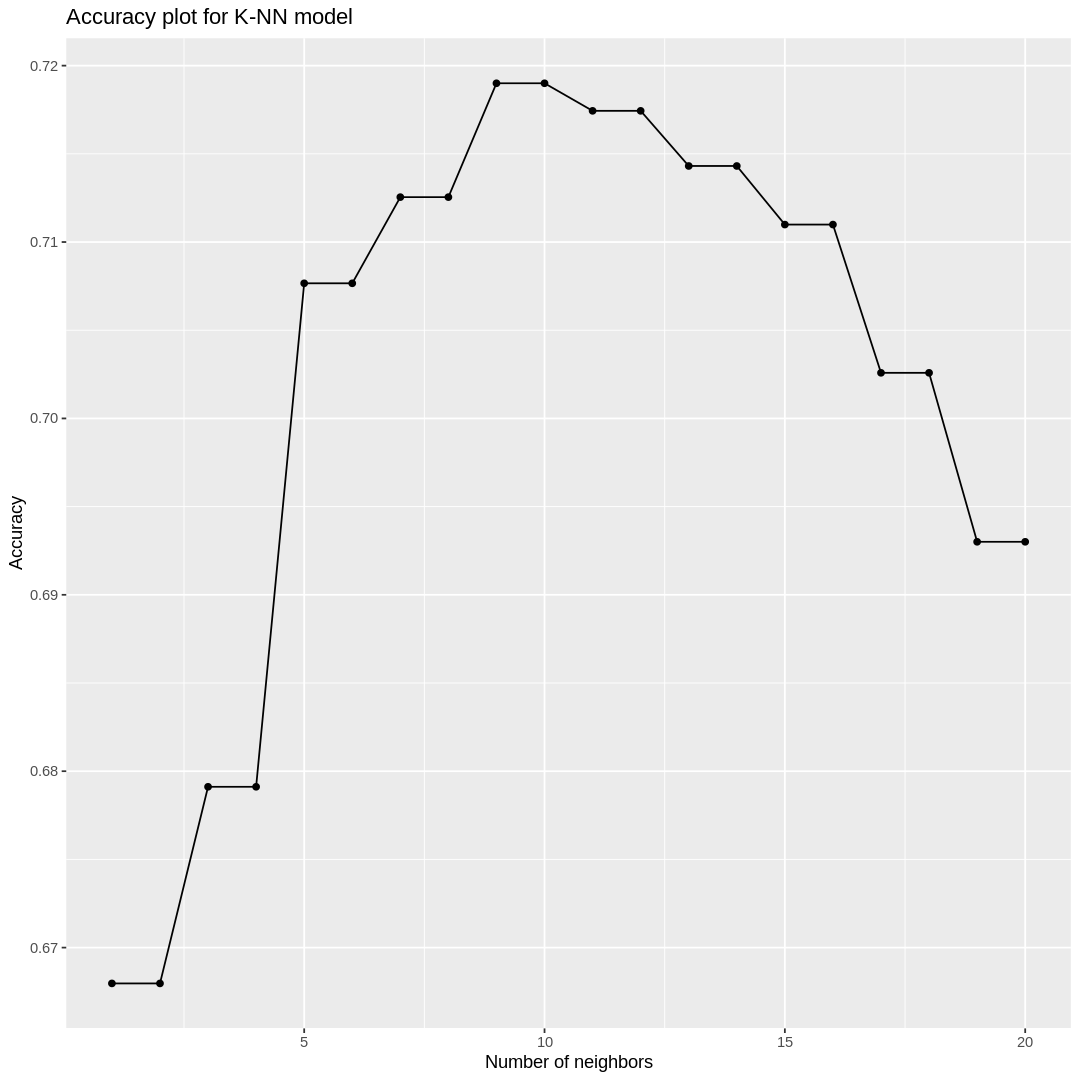

In [7]:
taiwanese_metrics |> filter(.metric == "accuracy") |>
                     select(neighbors, mean) |>
                     ggplot(aes(x = neighbors, y = mean)) +
                     geom_line() +
                     geom_point() +
                     labs(title = "Accuracy plot for K-NN model",
                          x = "Number of neighbors",
                          y = "Accuracy")

We decided that both K = 9 and K = 10 were reasonable choices, as they provided the highest accuracy and did not have big variations from their adjacent values.

Next, we trained our final model using our best value for K.

In [8]:
best_k <- taiwanese_metrics |> arrange(-mean) |> select(neighbors) |> slice(1) |> pull()
taiwanese_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                  set_engine("kknn") |>
                  set_mode("classification")
taiwanese_fit <- workflow() |>
                 add_recipe(taiwanese_recipe) |>
                 add_model(taiwanese_spec) |>
                 fit(taiwanese_training)

To test how good this classifier is, we made predictions for the testing dataset and calculated the accuracy and confusion matrix.

In [9]:
taiwanese_predictions <- taiwanese_fit |>
                         predict(taiwanese_testing) |>
                         select(.pred_class) |>
                         bind_cols(taiwanese_testing)
head(taiwanese_predictions)
taiwanese_predictions |> metrics(truth = bankrupt, estimate = .pred_class)
taiwanese_predictions |> conf_mat(truth = bankrupt, estimate = .pred_class)

.pred_class,bankrupt,research_and_development_expense_rate,equity_to_liability
<fct>,<fct>,<dbl>,<dbl>
Yes,Yes,2.55e+07,0.01647411
Yes,Yes,0.00e+00,0.02398233
Yes,No,7.30e+08,0.01566307
No,No,5.09e+07,0.03488856
No,No,0.00e+00,0.03080087
No,No,1.90e+09,0.03657169


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7425220
kap,binary,0.1162684


          Truth
Prediction   No  Yes
       No  1224    5
       Yes  434   42

Based on the values of the confusion matrix, we also calculated the precision and recall of the model using "Yes" as the positive label.

In [12]:
# True positives: 42
# Total positive predictions: 42 + 395 = 476
# Total negative predictions: 42 + 5 = 47
tibble(precision = 42 / (42 + 434),
       recall = 42 / (42 + 5))

precision,recall
<dbl>,<dbl>
0.08823529,0.893617


For the test dataset, the model has a very low precision (0.0882) but a high recall (0.893). This seems like a reasonable precision-recall trade-off given the nature of the classification problem and the purpose of our model, as it will be discussed below.

## Discussion
To summarize our findings, the model shows that the estimated accuracy of the classifier on the test data was 74.25%, indicating the proportion of correctly classified observations. Taking into account "Yes" as the positive label, the precision was 8.824% and the recall was 89.36%. There were 42 true positives, 5 false negatives, 434 false positives, and 1224 true negatives. Although it can be improved, the accuracy of our classifier is good for this particular application, as task of predicting whether a company will go bankrupt involves too many factors and is too complex to be predicted with a much higher accuracy. The particular use planned for this modifier is not as critical as that of models to detect cancer, for example. This means that having some incorrect predictions is acceptable.

Overall, through the Taiwanese company data set, we were able to outline a model that classifies a state of bankruptcy based upon the development and research expense rate, as well as the equity-to-liability ratio. The model showcased the value of these specific, dynamic variables in terms of bankruptcy and the potential benefit of their inclusion in more standardized, rigorous models.

Comparing it to a hypothetical baseline classifier that always predicts the label "No", our model would have lower precision and accuracy but much higher recall. The proposed baseline classifier would have an accuracy of 97.24% due to the great oversampling of the "No" label, an accuracy of 100% with 0 false positives out of 0 positive predictions and a recall of 0% with 0 true positives of 47 actual positive observations. Based on these statistics, someone may claim that this baseline classifier is better than our classifier because of the higher accuracy and precision. However, such baseline classifier would not provide any useful information to companies wishing to implement better resource allocation strategies nor to investors interested in knowing what companies it is safe to invest in. In contrast, the high recall of our model indicates that, if a company is going to become bankrupt, our model has most likely predicted the "Yes" label for it. This makes it comparatively safe to invest in companies which have been labeled as "No" in our model and suggests that our model is more useful than the baseline classifier despite of its lower accuracy.

The success of our model also indicates that the research and development expense rate and equity-to-liability ratio are likely to have a big predictive power. Along with the domain information provided before, these findings support our hypothesis that companies investing more in forward-looking projects are indeed less likely to go bankrupt. Consideration for an optimal predictive model shall consequently go beyond simple consideration of debt, cash flow, and profitability. Rather, the inclusion of indicators such as the research and development rate utilized in our model would provide a more holistic description of a company's dynamics leading to bankruptcy. This shift from expansion efforts in order to account for potential upcoming financial failure is indicated by the nature of which corporate firms reduce cash spending on growth factors such as acquisitions (Zhang, 2022).

This does not mean that companies should spend all of their resources in long term investments. While the prolonged success of a company is predicated on consideration for potential variability in the future, prioritizing towards long-term aspects of a business might becomes counterproductive if short-term aspects of financials are overlooked in the process. When this happens, a company might fail to stay functioning in time to execute their long-term strategy, ultimately deeming that time, money, and effort redundant. Rather than that, companies should try to find an equilibrium between short-term and long-term investment to achieve success.

There is still a lot of room for further research regarding factors that affect the success of companies. We were only able to use two variable for our model. Future model should take into account how other variables also take an important role in business success. In addition, given the exploratory nature of our question, our model was trained using a single dataset from Taiwan. Future research could explore the existence of this trend in other parts of the world, as well as use different datasets to further confirm it.

## References
- Demirer, R., Kutan, A., & Chen, C. (2010). Do investors herd in emerging stock markets?: Evidence from the Taiwanese market. Journal of Economic Behavior & Organization, 76(2), 283-295. https://doi.org/10.1016/j.jebo.2010.06.013
- Hsiao, Y., Lo, M., Lin, C., & Lin, H. (2021). Portfolio of Intangible Investments and Production and Innovation Performance: Evidence from Taiwanese Manufacturing Firms*. Asian Economic Journal, 35(4), 345-362. https://doi.org/10.1111/asej.12254
- Zhang, E. Q. (2022). Why are distressed firms acquisitive? Journal of Corporate Finance, 72, 102126. https://doi.org/10.1016/j.jcorpfin.2021.102126 